# Reinforcement Learning for 2-player BattleCity-Nes

# Initialize runtime and install necessary packages
Install the necessary libraries.

The link https://github.com/MatPoliquin/stable-retro leads to the github directory that contains the environments.

Check https://github.com/MatPoliquin/stable-retro/tree/master/retro/data/stable/BattleCity-Nes to find the basic game data, actions and states,etc.

Once the installation is done, you can find the entire directory as it is on github on the path of google colab: /usr/local/lib/python3.7/dist-packages/retro

If conda: \\wsl$\Ubuntu-22.04\home\\$USERNAME\miniconda3\envs\\$ENVNAME\lib\python3.7\site-packages\retro\data\stable\BattleCity-Nes

In [1]:
!pip3 install opencv-python==4.0.1.23 git+https://github.com/MatPoliquin/baselines-fix.git git+https://github.com/MatPoliquin/stable-retro.git

MANUALLY: if google colab, upload the ROM to: /usr/local/lib/python3.7/dist-packages/retro/data/stable/BattleCity-Nes.

Next, copy all *.json files, Start.2P.state, and the game rom to /retro/data/stable/BattleCity-Nes/ (rewrite existing files).


# Import

Import necessary packages

In [2]:
import retro
import gym
import numpy as np
import collections
from PIL import Image 
import cv2              # sudo apt-get install libsm6 libxrender1 libfontconfig1
import torch
import torch.nn as nn
import random
from tqdm import tqdm
import pickle


# !rm *.bk2 
# !rm *.mp4

try:
    env.close()
except NameError:
    pass

# Game setup
References (code, architecture, API):
- Gym wrappers: https://www.gymlibrary.dev/api/wrappers/
- Retro game integration: https://retro.readthedocs.io/en/latest/integration.html
- Retro API: https://retro.readthedocs.io/en/latest/python.html

In [3]:
"""
Define global variables and hyperparameters
"""

FRAMESKIP = 4
PIXEL_DOWNSCALE = 84
# RGB2GRAY_MAP = [0.299, 0.587, 0.114]      # standard RGB to grayscale mapping
RGB2GRAY_MAP = [0.033, 0.067, 0.900]        # use blue channel mainly because we want to differentiate between player and enemy tanks


"""
Map action indices to GYM input bits. 
In 2P mode, GYM inputs are 18 bits.
"""
action_index2bits = {
    0:    np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0]),
    1:    np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0]),
    2:    np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0]),
    3:    np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0]),
    4:    np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0]),
    5:    np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0]),
    6:    np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0]),
    7:    np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0]),
    8:    np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0]),
    9:    np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0]),
    10:    np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0]),
    11:    np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0]),
    12:    np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0]),
    13:    np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0]),
    14:    np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0]),
    15:    np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0]),
    16:    np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0]),
    17:    np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0]),
    18:    np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0]),
    19:    np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0]),
    20:    np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1]),
    21:    np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1]),
    22:    np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1]),
    23:    np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1]),
    24:    np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1]),
}

# Action table action_index2bits:
# [['UP'], ['UP']]
# [['DOWN'], ['UP']]
# [['LEFT'], ['UP']]
# [['RIGHT'], ['UP']]
# [['A'], ['UP']]
# [['UP'], ['DOWN']]
# [['DOWN'], ['DOWN']]
# [['LEFT'], ['DOWN']]
# [['RIGHT'], ['DOWN']]
# [['A'], ['DOWN']]
# [['UP'], ['LEFT']]
# [['DOWN'], ['LEFT']]
# [['LEFT'], ['LEFT']]
# [['RIGHT'], ['LEFT']]
# [['A'], ['LEFT']]
# [['UP'], ['RIGHT']]
# [['DOWN'], ['RIGHT']]
# [['LEFT'], ['RIGHT']]
# [['RIGHT'], ['RIGHT']]
# [['A'], ['RIGHT']]
# [['UP'], ['A']]
# [['DOWN'], ['A']]
# [['LEFT'], ['A']]
# [['RIGHT'], ['A']]
# [['A'], ['A']]

# DQN framework components
Our DQN framework is borrowed and modified from:
- DQN architecture: https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/
- DQN code on Super Mario Bros: https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/

In [4]:
class Skipaction(gym.Wrapper):
    """
    Every action lasts FRAMESKIP frames
    Modified from https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
    """
    def __init__(self, env=None, skip=FRAMESKIP):
        super(Skipaction, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip
        
        # always record
        # self.auto_record()

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, rewards_2p, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += rewards_2p[0] + rewards_2p[1]
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


In [5]:
class Downscale(gym.ObservationWrapper):
    """
    Downscales each frame to size PIXEL_DOWNSCALE x PIXEL_DOWNSCALE grayscale and removes margins and right panel
    Modified from https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
    """
    def __init__(self, env=None):
        super(Downscale, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=np.float32(0.0), high=np.float32(1.0), shape=(1, PIXEL_DOWNSCALE, PIXEL_DOWNSCALE), dtype=np.float32)
        
        # always record
        # self.auto_record()

    def observation(self, obs):
        return self.process(obs)

    def process(self, frame):
        # num of boundary pixels in raw obs
        bp = 8 
        if frame.size == 224 * 240 * 3:
            img = np.reshape(frame, [224, 240, 3]).astype(np.float32)
        else:
            ValueError("Unknown resolution") 
            
        # crop to remove the right panel
        # and then RGB to grayscale
        img = img[bp:-bp, bp:224-bp, 0] * RGB2GRAY_MAP[0] + img[bp:-bp, bp:224-bp, 1] * RGB2GRAY_MAP[1] + img[bp:-bp, bp:224-bp, 2] * RGB2GRAY_MAP[2]
        img = cv2.resize(img, (PIXEL_DOWNSCALE, PIXEL_DOWNSCALE), interpolation=cv2.INTER_AREA)
        
        # normalize to [0, 1]
        img = img / 255.0
        
        # reshape to (1, PIXEL_DOWNSCALE, PIXEL_DOWNSCALE)
        img = np.expand_dims(img, 0)
        return img


In [6]:
class BufferWrapper(gym.ObservationWrapper):
    """
    Modified from https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
    """
    def __init__(self, env, skip=FRAMESKIP, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        self.observation_space = gym.spaces.Box(env.observation_space.low.repeat(skip, axis=0),
                                                env.observation_space.high.repeat(skip, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

In [7]:
class Net_2p(nn.Module):
    """
    CNN-FNN architecture
    Modified from https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/
    """
    def __init__(self, input_shape, n_actions):
        super(Net_2p, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)


In [8]:
class DQNAgent:
    """
    Main DQN agent algorithm
    Modified from https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/
    """
    def __init__(self, state_space, n_actions, max_memory_size, batch_size, gamma, lr, exploration_max, exploration_min, exploration_decay, double_dqn, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.n_actions = n_actions
        self.double_dqn = double_dqn
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("Device:", self.device)
        
        # Double DQN network
        if self.double_dqn:  
            self.local_net = Net_2p(state_space, n_actions).to(self.device)
            self.target_net = Net_2p(state_space, n_actions).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("DQN1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("DQN2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  
            self.step = 0
        # DQN network
        else:  
            self.dqn = Net_2p(state_space, n_actions).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("DQN.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device)
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        """Store the experiences in a buffer to use later"""
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
    
    def batch_experiences(self):
        """Randomly sample 'batch size' experiences"""
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]      
        return STATE, ACTION, REWARD, STATE2, DONE
    
    def act(self, state):
        """Epsilon-greedy action"""
        if self.double_dqn:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.n_actions)]])
        if self.double_dqn:
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
    
    def copy_model(self):
        """Copy local net weights into target net for DDQN network"""
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        """Use the double Q-update or Q-update equations to update the network weights"""
        if self.double_dqn and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return
    
        STATE, ACTION, REWARD, STATE2, DONE = self.batch_experiences()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dqn:
            target = REWARD + torch.mul((self.gamma * self.target_net(STATE2).max(1).values.unsqueeze(1)),  1 - DONE)
            current = self.local_net(STATE).gather(1, ACTION.long())
        else:
            target = REWARD + torch.mul((self.gamma * self.dqn(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() 
        self.optimizer.step() 

        self.exploration_rate *= self.exploration_decay
        
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)


In [9]:
from IPython import display
import matplotlib.pyplot as plt

def show_state(env, ep=0, info=""):
    """
    Show game progress
    Modified from https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
    """
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


In [10]:
def run(training_mode, pretrained, double_dqn, num_episodes=1000, exploration_max=1, batch=0):
    """
    Main function
    Modified from https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
    """
    if training_mode:
        env = retro.make(game="BattleCity-Nes",players=2,state="Start.2P.state",record=".")
    else:
        env = retro.make(game="BattleCity-Nes",players=2,state="Start.2P.state",record=".")
        
    env = Skipaction(env)
    env = Downscale(env)
    env = BufferWrapper(env)

    observation_space = env.observation_space.shape
    n_actions = len(action_index2bits)  
    assert(n_actions == 25)     # 25 actions for 2p

    agent = DQNAgent(state_space=observation_space,
                     n_actions=n_actions,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     exploration_max=exploration_max,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dqn=double_dqn,
                     pretrained=pretrained)
    
    total_rewards = []
    if training_mode and pretrained:
        with open("total_rewards.pkl", 'rb') as f:
            total_rewards = pickle.load(f)
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor(np.expand_dims(state,0))
        
        fired_1p = False
        fired_2p = False
        total_reward = 0
        while True:
            if not training_mode:
                show_state(env, ep_num, "Reward: "+str(round(total_reward,2)))
            action = agent.act(state)
            action_idx = action.item()
            # action_idx = 24     # for testing purpose
            actionbits = action_index2bits[action_idx].copy()
            
            ### THIS BLOCK IS NECESSARY (OTHERWISE CANNOT FIRE CONSECUTIVELY)
            if actionbits[8] == 1:          # 1p gonna fire
                if fired_1p:                # if fired last time without switching keys
                    actionbits[8] = 0
                    actionbits[0] = 1
                    fired_1p = False        # switching keys this time; skip next time
                else:
                    fired_1p = True         # not switching keys this time; switch next time
            
            if actionbits[-1] == 1:         # 2p gonna fire
                if fired_2p:                # if fired last time without switching keys
                    actionbits[-1] = 0
                    actionbits[9] = 1
                    fired_2p = False        # switching keys this time; skip next time
                else:
                    fired_2p = True         # not switching keys this time; switch next time
            ### THIS BLOCK IS NECESSARY
            
                
            state_next, action_reward, done, info = env.step(actionbits)
        
            action_reward += 0.02       # time reward
            if info["baselives"] == 1 and info["lives1p"] == 3 and info["lives2p"] == 3:
                action_reward -= 500     # protect base
            
        
            total_reward += action_reward         
            
            state_next = torch.Tensor(np.expand_dims(state_next,0))
            
            action_reward = torch.tensor([action_reward]).unsqueeze(0)
            
            done = torch.tensor([int(done)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, action_reward, state_next, done)
                agent.experience_replay()
            
            state = state_next
            
            # print(info)
            if done:
                break
        
        total_rewards.append(total_reward)
        
    print("Episode {} score = {}, average score = {}, total episodes = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards), len(total_rewards)))
    
    
    # Save the trained memory so that we can continue from where we stop using 'pretrained' = True
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dqn:
            torch.save(agent.local_net.state_dict(), "DQN1.pt")
            torch.save(agent.target_net.state_dict(), "DQN2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "DQN.pt")  
            
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")
    
    env.close()


# Main
Train from beginning.
WARNING: ONLY RUN IF YOU WANT TO OVERWRITE EXISTING MODEL!

In [11]:
run(training_mode=True, pretrained=False, double_dqn=True, num_episodes=200, exploration_max = 1)
!mkdir record_train_0
!mv *.bk2 record_train_0   

Continue training from existing model.

In [12]:
for iiter in range(1, 1000):
    print("iter:", iiter)
    run(training_mode=True, pretrained=True, double_dqn=True, num_episodes=200, exploration_max = 0.1) 
    dirname = "record_train_" + str(iiter)
    !mkdir $dirname
    !mv *.bk2 $dirname  

Test. This will print out the game progress.

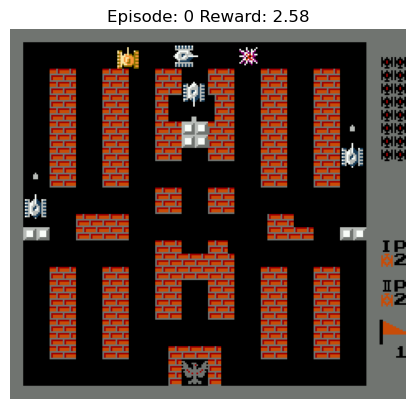

100%|██████████| 1/1 [00:11<00:00, 11.36s/it]

Episode 1 score = 2.600000000000002, average score = 2.600000000000002, total episodes = 1


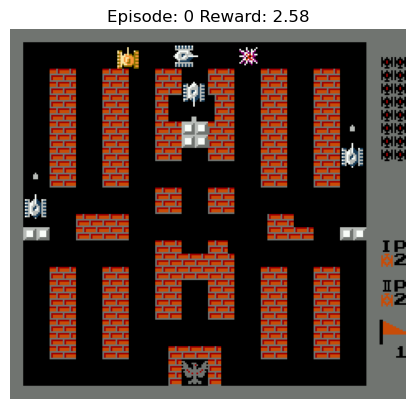

In [13]:
run(training_mode=False, pretrained=True, double_dqn=True, num_episodes=1, exploration_max = 0.02)

Create a playback movie of the .bk2 file to generate a .mp4 file at the current directory.

In [14]:
# !python3 -m retro.scripts.playback_movie *.bk2

Load all history runs and sort by rewards

In [ ]:
import pickle 
with open("total_rewards.pkl", 'rb') as f:
    total_rewards = pickle.load(f)
    
print([i for i in sorted(enumerate(total_rewards), key=lambda x:x[1], reverse=True)])
# len(total_rewards)